In [1]:
# Este programa calcula los errores de medidas espectrales segun el nuevo metodo (Metrologia, 2020).
# Intenta ser lo mas autocontenido posible, solo requiriendo una plantilla .xlsx como la adjunta.
# Los errores del factor Q estan calculados aparte y se propagan como podemos.
# Todo lo demas se calcula en el propio programa, excepto las incertidumbres del CN y SH, que son siempre iguales.

import numpy as np
from scipy.integrate import simps, quad
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import scipy.constants as ct
import scipy.special as sp
import time
import os
from scipy.stats import *
import pandas as pd

# Parametros para las graficas.

# Codigo de colores para daltonicos. Es posible utilizar otros.
#plt.style.use('tableau-colorblind10')

# El que usamos es la version Original Tableau 10 que se puede ver en este link:
# https://www.tableau.com/about/blog/2016/7/colors-upgrade-tableau-10-56782

from matplotlib import rc, rcParams

rcParams['figure.figsize'] = [8.0, 6]
rcParams['xtick.labelsize']  = 20
rcParams['xtick.major.size']  = 12
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.labelsize']  = 20
rcParams['ytick.major.size']  = 12
rcParams['ytick.major.width'] = 1.5
rcParams['axes.linewidth'] = 1.5
rcParams['lines.linewidth'] = 3
rcParams['lines.markersize'] = 10
rcParams['axes.titlesize'] = 25
rcParams['axes.labelsize'] = 25
rcParams['legend.fontsize'] = 18
rcParams['legend.frameon'] = False

rc("text", usetex=True)
rc('font', family='serif') # Los dos comandos son necesarios para utilizar LaTeX en las graficas.

def planck(wav,T): #Micras y Kelvin
    c1 = 2.0*0.59552*1.0E8
    c2 = 14338.0
    temp1 = wav**5
    temp2 = np.exp(c2/(wav*T))
    return c1/(temp1*(temp2-1.0)) #Unidades de W m-2 um-1 sr-1

In [2]:
# Importamos datos.

df = pd.read_excel(r'Plantilla.xlsx',header=None,skiprows=4) # Para que no interprete las primeras filas.
raw_input = df.to_numpy(float) # Convertido a una matriz o array de NumPy

# Importamos emisividades.

emisividades = pd.read_excel(r'Plantilla.xlsx',header=None, sheet_name="Emisividades",skiprows=2) # Segunda hoja.
raw_emis = emisividades.to_numpy(dtype=float)

# Importamos parametros.

param = pd.read_excel(r'Plantilla.xlsx',header=None,sheet_name="Parametros",skiprows=3)
raw_params = param.to_numpy(float)

#-----------------------------------
# Cargamos datos en arrays ordenados.
# Como no puedo mezclar strings y floats, he utilizado una plantilla antiintuitiva, que hay que trasponer.

raw_input = raw_input.transpose()

temp_bb1_I = raw_input[0,0] + 273.15
temp_bb1_F = raw_input[1,0] + 273.15
av_temp_bb1 = np.average([temp_bb1_I,temp_bb1_F])
temp_bb2 = raw_input[2,0] + 273.15
emi_bb1 = raw_input[3,0]
u_ebb1 = raw_input[4,0]
emi_bb2 = raw_input[5,0]
u_ebb2 = raw_input[6,0] # Explicadas en el articulo.

angles = raw_input[7,:]
n_angles = angles.shape[0]
print("Numero de angulos: ",n_angles)

temp_s_C = np.array((4,n_angles),dtype=float)
temp_s_C = raw_input[8:12,:]
print("Temperaturas de muestra:")
print(temp_s_C)
temp_s = temp_s_C + 273.15

temp_sur_C = np.array((4,n_angles),dtype=float)
temp_sur_C = raw_input[12:16,:]
print("Temperaturas de camara:")
print(temp_sur_C)
temp_sur = temp_sur_C + 273.15

lambdas = raw_emis[:,0]
n_lambdas = lambdas.shape[0]
print("Numero de longitudes de onda: ",n_lambdas)

planck_s = np.zeros((n_lambdas,n_angles),dtype=float)
for j in range(n_angles): # Convencion: i para las longitudes de onda, j para las temperaturas o angulos.
    av_temp_s = np.average(temp_s,axis=0)
    planck_s[:,j] = planck(lambdas[:],av_temp_s[j])

planck_sur = np.zeros((n_lambdas,n_angles),dtype=float)
for j in range(n_angles):
    av_temp_sur = np.average(temp_sur,axis=0)
    planck_sur[:,j] = planck(lambdas[:],av_temp_sur[j])

planck_bb1 = planck(lambdas,av_temp_bb1)
planck_bb2 = planck(lambdas,temp_bb2)

emis = raw_emis[:,1:]

# Calculamos el factor Q a partir de la emisividad y las temperaturas.

factorQ = np.zeros((n_lambdas,n_angles),dtype="float")

for j in range(n_angles):
    factorQ[:,j] = (emis[:,j]*(planck_s[:,j]-planck_sur[:,j])+planck_sur[:,j]-emi_bb1*planck_bb1[:])/(emi_bb1*planck_bb1[:]-emi_bb2*planck_bb2[:])

# Ahora importamos las incertidumbres estandar del factor Q (ya contiene el error del factor a).

u_factorQ = raw_params[:,1:8]

# Despreciamos la no linealidad y la deriva del FTIR, considerando solo errores de señal y calibracion.

Numero de angulos:  8
Temperaturas de muestra:
[[201.4 201.4 201.4 201.4 201.4 201.4 201.4 201.4]
 [202.6 202.6 202.6 202.6 202.6 202.6 202.6 202.6]
 [201.5 201.5 201.5 201.5 201.5 201.5 201.5 201.5]
 [202.4 202.4 202.4 202.4 202.4 202.4 202.4 202.4]]
Temperaturas de camara:
[[18.4 18.4 18.4 18.4 18.4 18.4 18.4 18.4]
 [18.6 18.6 18.6 18.6 18.6 18.6 18.6 18.6]
 [19.2 19.2 19.2 19.2 19.2 19.2 19.2 19.2]
 [19.3 19.3 19.3 19.3 19.3 19.3 19.3 19.3]]
Numero de longitudes de onda:  856


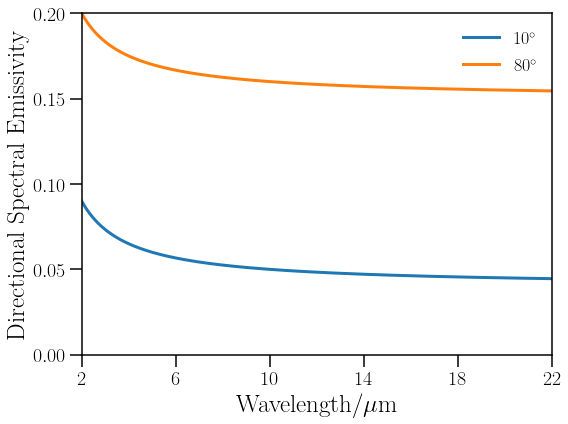

In [3]:
# Representacion de prueba.

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(lambdas, emis[:,0],label=r"10$^{\circ}$") # La r indica que es un string a interpretar por Latex.
ax.plot(lambdas, emis[:,-1],label=r"80$^{\circ}$")

ax.set(xlabel=r'Wavelength/$\mu$m', ylabel='Directional Spectral Emissivity')
ax.set_xlim(2,22)
ax.set_ylim(0,0.2)
ax.set_yticks([0,0.05,0.1,0.15,0.2])
ax.set_xticks([2,6,10,14,18,22])

ax.legend(loc="best")
fig.tight_layout() # Para evitar que se salga de los margenes.
plt.show()

#fig.savefig("test.pdf",bbox_to_anchor="tight")

In [4]:
# Calculamos las incertidumbres de cada medida de temperatura.
# ddof=1 es lo que hace que el denominador sea N-1.

u_temp_bb1_A = np.std([temp_bb1_I,temp_bb1_F],ddof=1)/np.sqrt(2.0) # Incertidumbre tipo A: estadistica (dos medidas).
u_temp_bb1_B = np.sqrt(1.0**2.0+0.3**2.0) # La referencia esta en el articulo.
u_temp_bb1 = np.sqrt(u_temp_bb1_A**2+u_temp_bb1_B**2)

# No puedo usar el truco bayesiano mencionado en el paper para agrandar la incertidumbre de una medida de dos puntos.
# Por tanto, estamos infravalorando esa fuente de incertidumbre, aunque no es significativo.

u_temp_bb2 = 2.2/np.sqrt(3.0) # Explicado en el articulo.

# Temperaturas medias e incertidumbres de los termopares.
# La fuente de tipo B tiene un ciclo if por ser una funcion definida a trozos.

av_temp_s = np.average(temp_s,axis=0)
u_temp_s_A = np.sqrt((4.0-1.0)/(4.0-3.0)) * np.std(temp_s,axis=0,ddof=1)/np.sqrt(4.0) # El prefactor es bayesiano.
u_temp_s_B = np.zeros_like(u_temp_s_A)
for j in range(n_angles):
    test_factor = 0.0075*(av_temp_s[j]-273.15)
    if (test_factor>2.2):
        u_temp_s_B[j] = test_factor/np.sqrt(3.0)
    else:
        u_temp_s_B[j] = 2.2/np.sqrt(3.0)
u_temp_s = np.sqrt(u_temp_s_A**2 + u_temp_s_B**2)

# Temperaturas medias e incertidumbres de termopares de camara.
# Como son temperaturas bajas, el error tipo B siempre va a ser 2.2/np.sqrt(3.0).

av_temp_sur = np.average(temp_sur,axis=0)
u_temp_sur_A = np.sqrt((4.0-1.0)/(4.0-3.0)) * np.std(temp_sur,axis=0,ddof=1)/np.sqrt(4.0)
u_temp_sur_B = 2.2/np.sqrt(3.0)
u_temp_sur = np.sqrt(u_temp_sur_A**2 + u_temp_sur_B**2)

In [5]:
#------------------------------------
# Derivadas parciales.
#------------------------------------

def parcial_Q(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh): # Ponemos todos los parametros en cada definicion para no dejarnos ninguno.
    return (Ebb*Lbb-Esh*Lsh)/(Ls-Lsur)

def parcial_Ls(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh):
    numerador = Ebb*Lbb+Q*(Ebb*Lbb-Esh*Lsh)-Lsur
    denominador = (Ls-Lsur)**2.0
    return -1.0*numerador/denominador

def parcial_Lsur(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh):
    numerador = Ebb*Lbb+Q*(Ebb*Lbb-Esh*Lsh)-Lsur
    denominador = (Ls-Lsur)**2.0
    return (-1.0/(Ls-Lsur) + numerador/denominador)

def parcial_Lbb(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh):
    numerador = Ebb*(1.0+Q)
    denominador = Ls-Lsur
    return numerador/denominador

def parcial_Lsh(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh):
    numerador = Esh*Q
    denominador = Ls-Lsur
    return -1.0*numerador/denominador

def parcial_Ebb(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh):
    numerador = Lbb*(1.0+Q)
    denominador = Ls-Lsur
    return numerador/denominador

def parcial_Esh(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh):
    numerador = Q*Lsh
    denominador = Ls-Lsur
    return -1.0*numerador/denominador

def parcial_Ti(Li,Ti,Wavi):
    c2 = 14338.0
    numerador = Li*c2*np.exp(c2/(Wavi*Ti))
    denominador = (Wavi*Ti**2.0)*(np.exp(c2/(Wavi*Ti))-1.0)
    return numerador/denominador

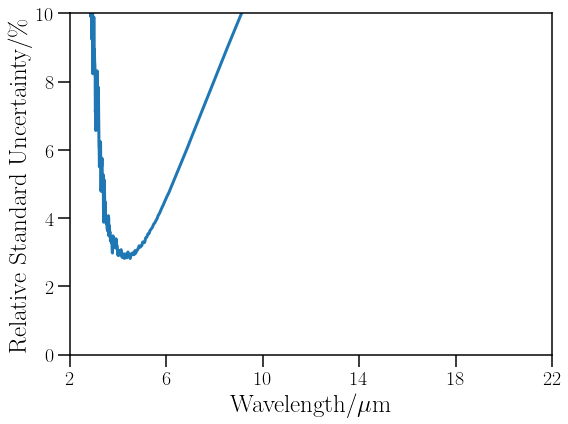

In [6]:
#----------------------------------------------------------
# Incertidumbre estandar combinada.
#----------------------------------------------------------

u_combined = np.zeros_like(emis,dtype=float)

#---------------------------------------------------------------------------
# IMPORTANTE: EL ERROR DEL FACTOR Q SE TIENE QUE INTRODUCIR A MANO EN LA PLANTILLA.
# Convertimos la temperatura a un numero de columna quitandole 200 C y escalando.

temperatura_factorQ = temp_sur_C = raw_input[16,0]
contador = int((temperatura_factorQ-200)/100)
u_factorQ_ele = u_factorQ[:,contador]
#---------------------------------------------------------------------------

for j in range(n_angles):
    Q = factorQ[:,j]
    Ls = planck_s[:,j]
    Lsur = planck_sur[:,j]
    Lbb = planck_bb1[:]
    Lsh = planck_bb2[:]
    Ebb = emi_bb1
    Esh = emi_bb2
    Ts = av_temp_s[j]
    Tsur = av_temp_sur[j]
    Tbb = av_temp_bb1
    Tsh = temp_bb2
    Wavi = lambdas[:]
    u_combined[:,j] = ((parcial_Q(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh)*u_factorQ_ele[:])**2.0
                           + (parcial_Ls(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh)*parcial_Ti(Ls,Ts,Wavi)*u_temp_s[j])**2.0
                           + (parcial_Lsur(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh)*parcial_Ti(Lsur,Tsur,Wavi)*u_temp_sur[j])**2.0
                           + (parcial_Lbb(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh)*parcial_Ti(Lbb,Tbb,Wavi)*u_temp_bb1)**2.0
                           + (parcial_Lsh(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh)*parcial_Ti(Lsh,Tsh,Wavi)*u_temp_bb2)**2.0
                           + (parcial_Ebb(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh)*u_ebb1)**2.0
                           + (parcial_Esh(Q,Ls,Lsur,Lbb,Lsh,Ebb,Esh)*u_ebb2)**2.0)
    u_combined[:,j] = np.sqrt(u_combined[:,j])

#-----------------------------------------------------------------
# Exportamos los errores obtenidos
#-----------------------------------------------------------------

# Comprobamos si hay una carpeta llamada Output en el directorio actual. Si no, la creamos.
newpath = r'./Output' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

np.savetxt("Output/u_combined_k1.csv", u_combined, delimiter=",")

#-----------------------------------------------------------------
# Verificacion rapida del resultado por el metodo grafico.

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(lambdas, 100*u_combined[:,0]/emis[:,0])

ax.set(xlabel=r'Wavelength/$\mu$m', ylabel=r'Relative Standard Uncertainty/\%')
ax.set_xlim(2,22)
ax.set_ylim(0,10)
ax.set_xticks([2,6,10,14,18,22])

fig.tight_layout()
plt.show()

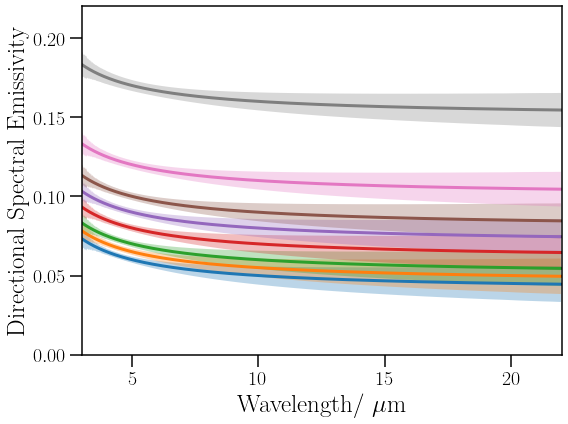

In [7]:
# Ahora procedemos al calculo de la hemisferica.

# Primero aplicamos cutoffs.

cutoff_cortas = 3.0
cutoff_largas = 22.0

columns = np.zeros((2,n_angles),dtype=int)

for j in range(n_angles):
    for i in range(n_lambdas):
        if (lambdas[i]>=cutoff_cortas):
            columns[0,j] = i
            break

for j in range(n_angles):
    for i in range(n_lambdas):
        if (lambdas[i]>=cutoff_largas):
            columns[1,j] = i
            break

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_ylim(0.0,0.22)
ax.set_xlim(3.0,22.0)
ax.set_ylabel('Directional Spectral Emissivity', size=25)
ax.set_xlabel('Wavelength/ $\mu$m', size=25)

ax.tick_params(axis='both', which='major', labelsize=20)

for j in range(n_angles):
    ax.plot(lambdas[columns[0,j]:columns[1,j]],emis[columns[0,j]:columns[1,j],j],linewidth=3.0)
    ax.fill_between(lambdas[columns[0,j]:columns[1,j]],(emis[columns[0,j]:columns[1,j],j]-u_combined[columns[0,j]:columns[1,j],j]),(emis[columns[0,j]:columns[1,j],j]+u_combined[columns[0,j]:columns[1,j],j]),alpha=0.3)

fig.tight_layout()
plt.show()

fig.savefig("Output/direccionales_sombras.pdf",bbox_to_anchor="tight")

In [8]:
# Ahora toca definir las funciones para la extrapolacion. Basado en el libro de Siegel.

def integrando_siegel(x):
    return x**3/(np.exp(x)-1)

def integral_siegel(l,t): # Cantidad de radiacion entre lambda=0 y lambda=l.
    l_SI = l*1.0E-6 # Input en micras.
    c2 = ct.h*ct.c/ct.k
    x = c2/(l_SI*t)
    resultado = quad(integrando_siegel,0,x)
    return 1.0-15.0*resultado[0]/np.pi**4

def emi_total_siegel(emis,ec,el,radiancias,lambdas,temp): #ec es la emi a cortas y el a largas.
    extrapolacion = ec*integral_siegel(lambdas[0],temp) + el*(1.0-integral_siegel(lambdas[-1],temp))
    emis_pesadas = emis*radiancias
    numerador = simps(emis_pesadas,lambdas)
    denominador = simps(radiancias,lambdas) + integral_siegel(lambdas[0],temp) + (1.0-integral_siegel(lambdas[-1],temp)) # Si no, solo integramos el denominador en el rango en el que tenemos datos experimentales.
    return ((numerador/denominador) + extrapolacion)

In [9]:
# Numero restringido de tiradas para el primer test.
# Cambiar a  2.0E5 para intentos mas serios.

n_runs = int(1000)

emis_montecarlo = np.zeros(n_angles,dtype=float)
errores_montecarlo = np.zeros(n_angles,dtype=float)

histograma = np.zeros((n_runs,n_angles),dtype=float)

# Seedear con time() es mala praxis, ya que obtenemos siempre numeros muy parecidos.
# He usado /dev/random para generar un numero aleatorio de verdad de 32 bits.

semilla = 3717303722 # Un numero de alta entropia para evitar problemas.
np.random.seed(semilla)

for j in range(n_angles):
    
    # Preparamos las variables que seran llenadas con numeros aleatorios.
    
    i_min = columns[0,j]
    i_max = columns[1,j]
        
    emis_rand = np.zeros_like(emis[:,j])
    temp_rand = np.zeros_like(av_temp_s[j])
    emi_rand_a = np.zeros(1,dtype=float)
    emi_rand_b = np.zeros_like(emi_rand_a)
    planck_rand = np.zeros_like(planck_s[:,j])
       
    print("Temperatura: ", av_temp_s[j]-273.15, r" $^{\circ}$C")
    print("Tirada numero:",j+1)
    
    ec = emis[columns[0,j],j]
    el = emis[columns[1,j],j]
    
    error = np.zeros(1,dtype=float)
    temp_rand = av_temp_s[j]
    
    for k in range(n_runs):
        emi_rand_a = np.random.uniform(low=ec,high=1.0)
        emi_rand_b = np.random.uniform(low=0.0,high=el)
        error = np.random.normal(0,1)
        for i in range(i_min,i_max):
            emis_rand[i] = emis[i,j]+u_combined[i,j]*error # TODOS MULTIPLICADOS POR UN FACTOR PROPORCIONAL.
            planck_rand[i] = planck(lambdas[i],temp_rand)
        result = emi_total_siegel(emis_rand,emi_rand_a,emi_rand_b,planck_rand,lambdas,temp_rand)
        histograma[k,j] = result
    
    mu = np.mean(histograma[:,j])
    sigma = np.std(histograma[:,j])
    
    print("Media: ",mu,", y desviacion estandar: ",sigma, ". Error relativo: ",100.0*sigma/mu, "%.")
    print("Kurtosis: ",kurtosis(histograma[:,j],fisher=True))
    print("Test de asimetria: ",skewtest(histograma[:,j]))
    emis_montecarlo[j] = mu
    errores_montecarlo[j] = sigma
    
    # Ploteamos una gaussiana para comparar.
    # Quitar los comentarios para visualizar las distintas distribuciones.
    
    #fig = plt.figure(figsize=(8,6))
    #ax = fig.add_subplot(111)
    
    #ax.set_ylabel('Draws')
    #ax.set_xlabel('Total Normal Emissivity')
    
    #plt.hist(histograma[:,j], bins=30, density=True) # Hemos sustituido norm por density.
    #xmin, xmax = plt.xlim()
    #x = np.linspace(xmin, xmax, 100)
    #y = norm.pdf(x, mu, sigma)
    #plt.plot(x, y,linewidth=3.0)
    
    #fig.tight_layout()
    #plt.show()

#np.savetxt("Output/histograma.csv",histograma,delimiter=",")
np.savetxt("Output/emis_montecarlo.csv",emis_montecarlo,delimiter=",")
np.savetxt("Output/errores_montecarlo.csv",errores_montecarlo,delimiter=",")

Temperatura:  201.97499999999997  $^{\circ}$C
Tirada numero: 1
Media:  0.05465992226493494 , y desviacion estandar:  0.005158476368293743 . Error relativo:  9.437401581529459 %.
Kurtosis:  0.04420126386234147
Test de asimetria:  SkewtestResult(statistic=-1.5004001440576953, pvalue=0.13351078224832957)
Temperatura:  201.97499999999997  $^{\circ}$C
Tirada numero: 2
Media:  0.059935907174732767 , y desviacion estandar:  0.005096612603643609 . Error relativo:  8.503437828654729 %.
Kurtosis:  0.16321441998766284
Test de asimetria:  SkewtestResult(statistic=0.8864574519038084, pvalue=0.3753710721314689)
Temperatura:  201.97499999999997  $^{\circ}$C
Tirada numero: 3
Media:  0.06476999549188983 , y desviacion estandar:  0.005260558297001508 . Error relativo:  8.121906226873534 %.
Kurtosis:  -0.21693378681608078
Test de asimetria:  SkewtestResult(statistic=1.0741802328099885, pvalue=0.28274191012461414)
Temperatura:  201.97499999999997  $^{\circ}$C
Tirada numero: 4
Media:  0.0747671801606607 , 

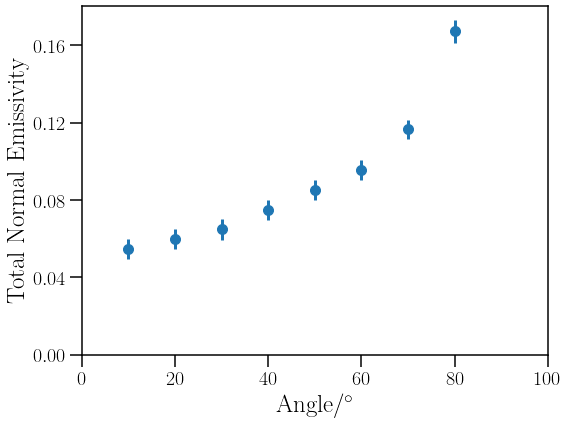

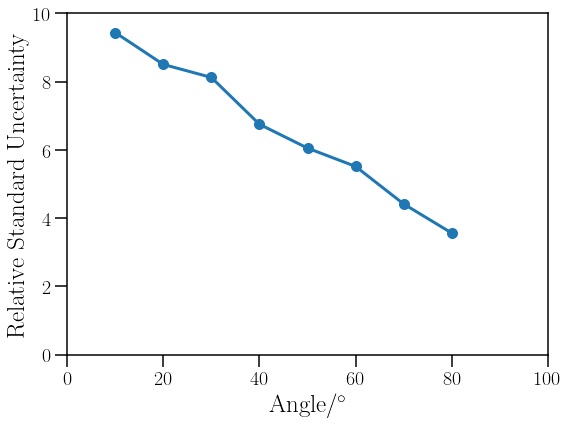

In [10]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

angles = np.array([10,20,30,40,50,60,70,80],dtype=float)

ax.set_ylim(0,0.18)
ax.set_xlim(0,100)
ax.set_yticks([0,0.04,0.08,0.12,0.16])

ax.set_ylabel('Total Normal Emissivity', size=25)
ax.set_xlabel('Angle/$^{\circ}$', size=25)
ax.tick_params(axis='both', which='major', labelsize=20)

ax.errorbar(angles,emis_montecarlo, yerr=errores_montecarlo,fmt="o")

fig.tight_layout()
plt.show()

fig.savefig("Output/total_normal.pdf",bbox_inches="tight")

#--------------------------------------

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_ylim(0,10)
ax.set_xlim(0,100)
ax.set_ylabel('Relative Standard Uncertainty')
ax.set_xlabel('Angle/$^{\circ}$')

ax.plot(angles,100*errores_montecarlo/emis_montecarlo,zorder=2)
ax.scatter(angles,100*errores_montecarlo/emis_montecarlo,zorder=1) # Para poner los puntos por encima de la linea.

fig.tight_layout()
plt.show()

fig.savefig("Output/u_total_relativo.pdf",bbox_inches="tight")

In [11]:
# Ahora tenemos que incluir los angulos 0 y 90 para integrar en hemisferica.

angles = np.array([0,10,20,30,40,50,60,70,80,90],dtype=float)
xradians = np.radians(angles)
n_angles_new = angles.shape[0]

totales = np.zeros(n_angles_new,dtype=float)
errores = np.zeros(n_angles_new,dtype=float)

totales[0] = emis_montecarlo[0]
errores[0] = errores_montecarlo[0]
for j in range(1,n_angles_new-1):
    totales[j] = emis_montecarlo[j-1]
    errores[j] = errores_montecarlo[j-1]
totales[-1] = 0
errores[-1] = 0

Hemisferica:  0.08615010846088883 e incertidumbre estandar:  0.005160852307506733


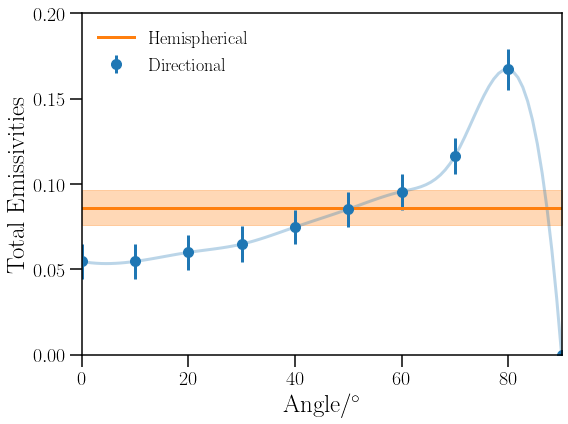

In [12]:
# Consideramos los datos correlacionados. Si asumimos que no hay correlacion, las pequenas oscilaciones individuales se 
# compensan colectivamente.

M = int(1000) # De nuevo, subir a 2.0E5 cuando sea necesario.

semilla = 3717303722 # Reiniciamos la semilla para que este calculo y el anterior sean independientes.
# Por supuesto, se debe comprobar la independencia del resultado de la semilla empleada.
np.random.seed(semilla)

weight = np.sin(2.0*xradians)

histograma = np.zeros(M,dtype=float)
totales_temp = np.zeros(n_angles_new)

for k in range(M):
    tirada = np.random.normal(0,1)
    for j in range(n_angles_new):
        totales_temp[j] = totales[j]+errores[j]*tirada
        histograma[k] = simps(totales_temp*weight,xradians)

total_hemi = np.mean(histograma)
error_hemi = np.std(histograma)

print("Hemisferica: ",total_hemi, "e incertidumbre estandar: ",error_hemi)

f = interp1d(angles,totales,kind=3)
xnew = np.linspace(0,90,100)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

ax.set_ylabel('Total Emissivities')
ax.set_xlabel('Angle/$^{\circ}$')

ax.set_xlim(0.0,90.0)
ax.set_ylim(0,0.20)
ax.set_yticks([0,0.05,0.1,0.15,0.2])

ax.errorbar(angles,totales,yerr=2.0*errores,fmt="o",color="C0",label="Directional")
ax.plot(xnew,f(xnew),color="C0",alpha=.3)
ax.plot([0,90],[total_hemi,total_hemi],color="C1",label="Hemispherical")
ax.fill_between([0,90],total_hemi-2.0*error_hemi,total_hemi+2.0*error_hemi,color="C1",alpha=.3)

plt.legend(loc="best")
fig.tight_layout()
plt.show()

fig.savefig("Output/hemisferica.pdf",bbox_inches="tight")

np.savetxt("Output/emi_hemisferica.csv",[total_hemi,error_hemi],delimiter=",")